Full dataset created with 7200 records
Sample dataset created with 400 records

Random Forest Evaluation:
Warning Classifier Accuracy: 0.9880
Warning Classifier F1 Score: 0.9649
Days to Failure MAE: 3.6125
Days to Failure R²: 0.9660

Top 10 Features for Warning Prediction:
Voltage: 0.3708
Voltage_7d_mean: 0.2195
Voltage_7d_std: 0.1404
Voltage_trend: 0.0645
Humidity: 0.0569
Temperature: 0.0338
Humidity_7d_std: 0.0254
Humidity_7d_mean: 0.0240
Temperature_7d_mean: 0.0173
Temperature_7d_std: 0.0117

Visualizations saved for Device_1
Failure occurs at day 90


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


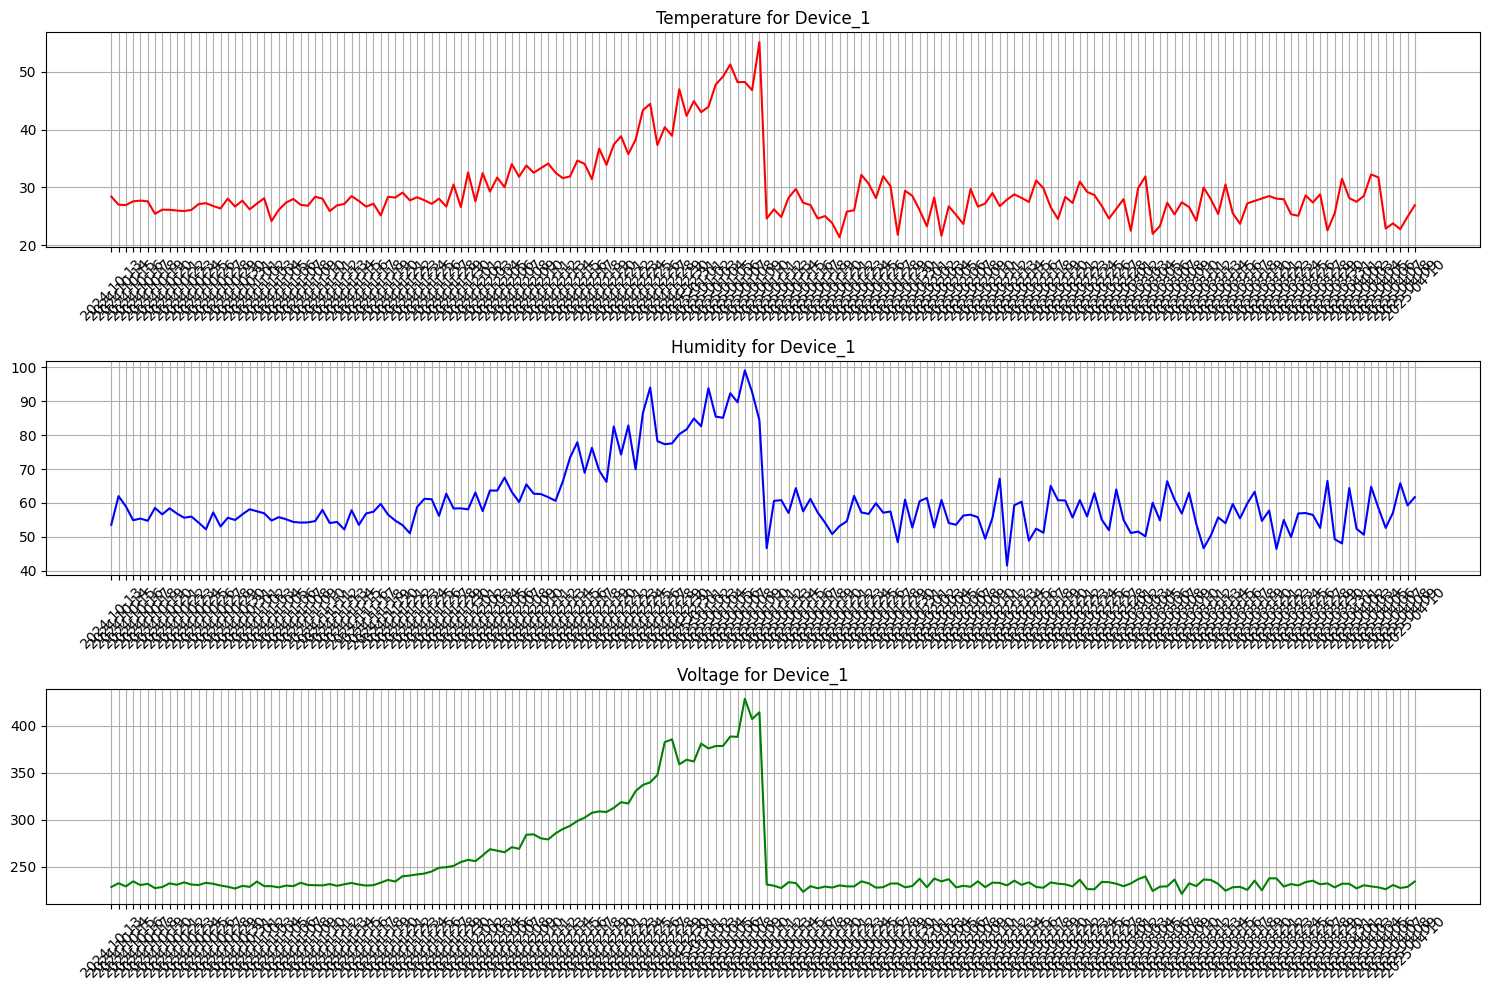

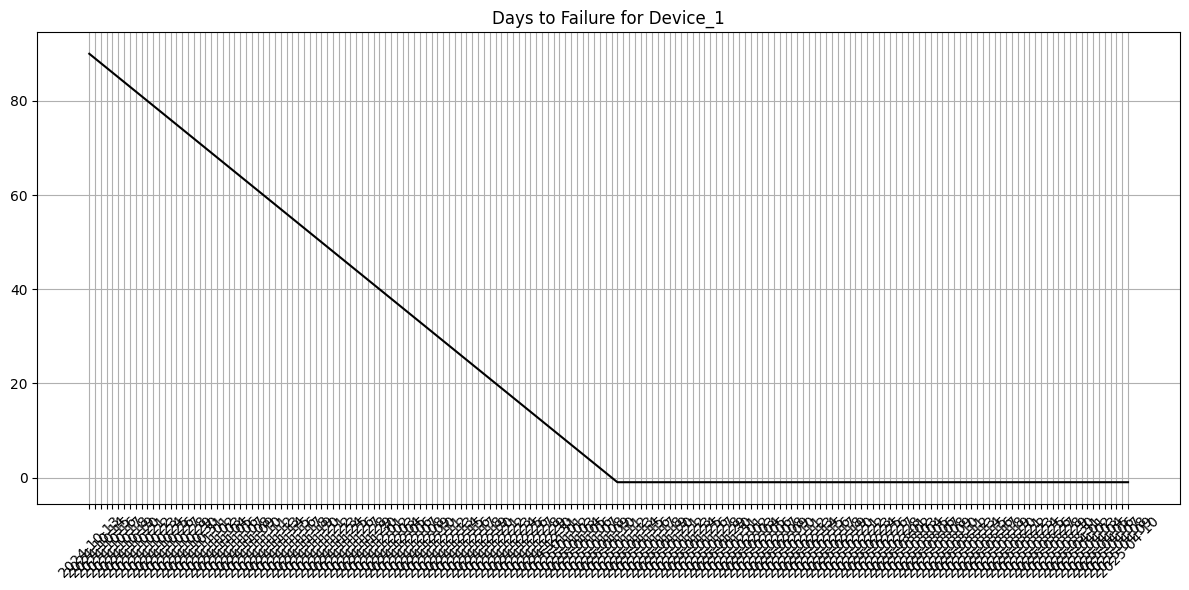

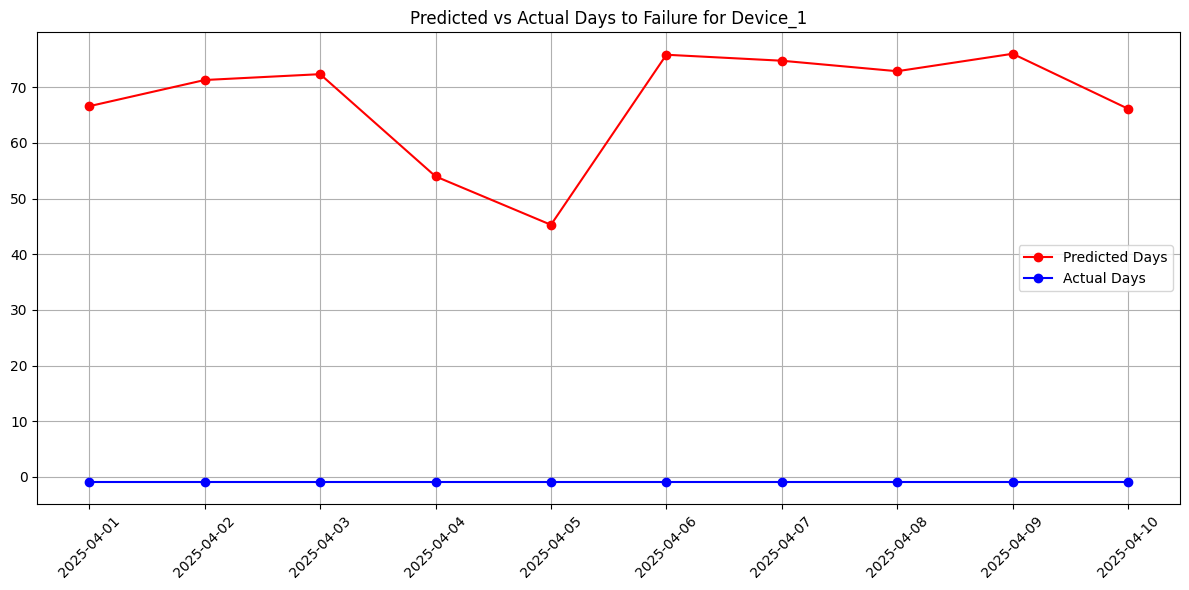

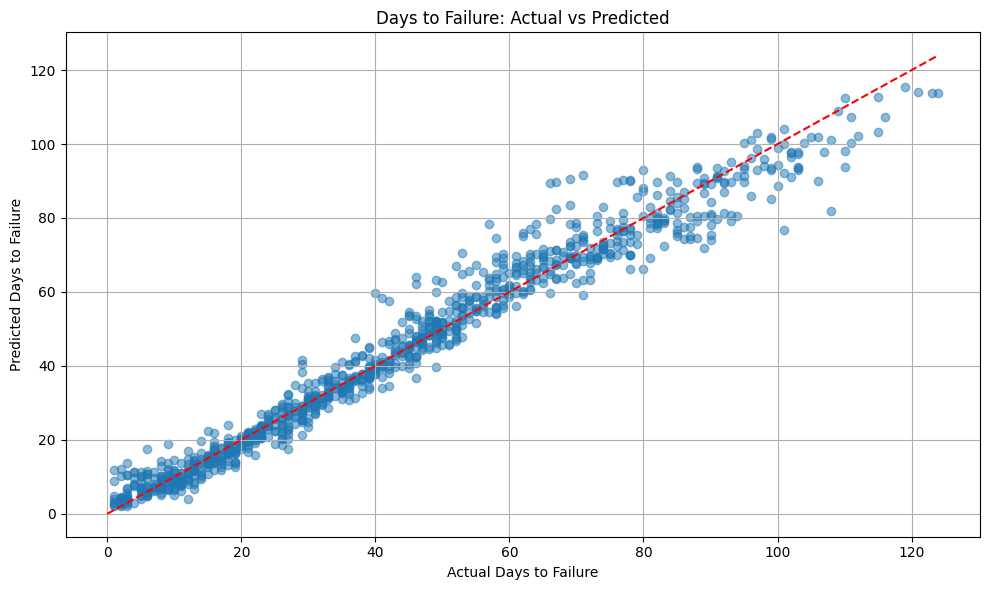

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
num_devices = 40  # 40 devices * 10 days = 400 records
num_days = 10     # For the sample dataset
full_history_days = 180  # Generate 6 months of history data

# Create empty dataframe
columns = ['Date', 'Device_ID', 'Temperature', 'Humidity', 'Voltage', 'Failure', 'Days_to_Failure']
data = []

# Generate realistic device profiles
def generate_device_profile():
    # Assign realistic server room parameters with some devices having suboptimal conditions
    profile = {
        # Temperature in Celsius (normal range: 18-27°C, some up to 35°C)
        'Temperature': np.random.choice([
            np.random.uniform(18, 22),    # Optimal (50% chance)
            np.random.uniform(22, 27),    # Normal (30% chance)
            np.random.uniform(27, 35)     # Suboptimal (20% chance)
        ], p=[0.5, 0.3, 0.2]),
        
        # Humidity in % (ideal: 45-55%, with some variability)
        'Humidity': np.random.choice([
            np.random.uniform(45, 55),     # Optimal (50% chance)
            np.random.uniform(35, 45),     # Low (25% chance)
            np.random.uniform(55, 65)      # High (25% chance)
        ], p=[0.5, 0.25, 0.25]),
        
        # Voltage in Volts (with some variance from ideal 220-240V)
        'Voltage': np.random.choice([
            np.random.uniform(220, 230),   # Stable (60% chance)
            np.random.uniform(210, 220),   # Slightly low (20% chance)
            np.random.uniform(230, 245)    # Slightly high (20% chance)
        ], p=[0.6, 0.2, 0.2])
    }
    
    # Calculate risk score based on profile (higher temp, voltage deviation and extreme humidity increase risk)
    risk_score = 0
    
    # Temperature risk (exponential risk increase with temperature)
    if profile['Temperature'] < 22:
        risk_score += 0.1
    elif profile['Temperature'] < 27:
        risk_score += 0.3
    else:
        # Exponential increase in risk for high temps
        temp_factor = (profile['Temperature'] - 27) / 8
        risk_score += 0.5 + temp_factor**2
    
    # Voltage risk (deviation from ideal 225V)
    voltage_deviation = abs(profile['Voltage'] - 225) / 15
    risk_score += voltage_deviation * 0.3
    
    # Humidity risk (deviation from ideal 50%)
    humidity_deviation = abs(profile['Humidity'] - 50) / 15
    risk_score += humidity_deviation * 0.2
    
    # Normalize risk score between 0.1 and 1
    risk_score = max(0.1, min(1.0, risk_score))
    profile['risk_score'] = risk_score
    
    return profile

# Generate device profiles with risk scores
device_profiles = {}
for device_id in range(1, num_devices + 1):
    device_profiles[device_id] = generate_device_profile()

# Determine failing devices - now ALL devices will fail
failing_devices = []
failure_days = {}

for device_id, profile in device_profiles.items():
    # Adjust risk score to ensure all devices fail but with appropriate timing
    adjusted_risk = max(0.3, profile['risk_score'])  # Minimum risk of 0.3 ensures eventual failure
    failing_devices.append(device_id)
    
    # Calculate a more predictable failure day based on risk score
    # Higher risk = earlier failure, lower risk = later failure
    max_fail_day = int(full_history_days * (1 - adjusted_risk * 0.8))
    # Make sure max_fail_day is at least 51 to avoid issues with min_fail_day calculation
    max_fail_day = max(max_fail_day, 51)
    
    # Calculate min_fail_day to be at least 50 days but less than max_fail_day
    min_fail_day = max(max_fail_day - 60, 50)
    if min_fail_day >= max_fail_day:
        min_fail_day = max_fail_day - 1
    
    # Assign failure day - more predictable pattern based on risk score
    failure_days[device_id] = np.random.randint(min_fail_day, max_fail_day)

# Generate more predictable time series with clear degradation patterns
def generate_time_series(base_value, num_days, std_dev, has_weekly_pattern=True, 
                         deterioration_start=None, failure_day=None, risk_score=0.5):
    """
    Generate realistic time series with:
    - Daily cycles (e.g., higher temps during day)
    - Weekly cycles (e.g., lower usage on weekends)
    - Gradual deterioration for failing devices
    - Clear precursor signals before failure
    """
    # Initialize with base value
    series = np.ones(num_days) * base_value
    
    # Add daily cycle pattern (sine wave with 24-hour period)
    days = np.arange(num_days)
    daily_cycle = np.sin(days * (2 * np.pi / 1)) * std_dev * 0.5
    series += daily_cycle
    
    # Add weekly pattern if specified
    if has_weekly_pattern:
        weekly_cycle = np.sin(days * (2 * np.pi / 7)) * std_dev * 0.3
        series += weekly_cycle
    
    # Add more pronounced gradual deterioration pattern for all devices
    if deterioration_start is not None and failure_day is not None:
        # Define deterioration curve based on risk score
        # Higher risk score = steeper deterioration curve
        deterioration_factor_multiplier = 0.15 + (risk_score * 0.2)
        
        for i in range(num_days):
            if i >= deterioration_start:
                # Calculate how far into deterioration process we are (0 to 1)
                progress = (i - deterioration_start) / max(1, (failure_day - deterioration_start))
                if i < failure_day:
                    # Exponential deterioration curve with steeper curve for higher risk devices
                    deterioration_factor = np.exp(progress * (1 + risk_score)) - 1
                    series[i] += deterioration_factor * base_value * deterioration_factor_multiplier
                    
                    # Add predictable spikes as failure approaches
                    if progress > 0.6:
                        # More frequent spikes for higher risk devices
                        spike_prob = progress * (0.3 + risk_score * 0.3)
                        if np.random.random() < spike_prob:
                            # Add a more pronounced spike
                            series[i] += np.random.uniform(0, base_value * (0.2 + risk_score * 0.1))
    
    # Add random noise (increasing variance for failing devices approaching failure)
    for i in range(num_days):
        noise_std = std_dev
        if deterioration_start is not None and failure_day is not None and i >= deterioration_start:
            progress = min(1.0, (i - deterioration_start) / max(1, (failure_day - deterioration_start)))
            noise_std *= (1 + progress * (1 + risk_score))
        
        series[i] += np.random.normal(0, noise_std)
    
    return series

start_date = datetime.now() - timedelta(days=full_history_days)

# Generate data for each device
for device_id in range(1, num_devices + 1):
    profile = device_profiles[device_id]
    is_failing = device_id in failing_devices  # Now always True
    
    # Determine deterioration parameters - now always set
    deterioration_start = None
    failure_day = None
    
    if is_failing:
        failure_day = failure_days[device_id]
        # More predictable deterioration window based on risk score
        deterioration_window = int(30 + (1 - profile['risk_score']) * 50)
        deterioration_start = max(0, failure_day - deterioration_window)
    
    # Generate time series for each parameter with risk score affecting pattern
    temp_series = generate_time_series(
        profile['Temperature'], full_history_days, 1.0, False,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    humidity_series = generate_time_series(
        profile['Humidity'], full_history_days, 2.0, True,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    voltage_series = generate_time_series(
        profile['Voltage'], full_history_days, 1.5, False,
        deterioration_start, failure_day, profile['risk_score']
    )
    
    # Create daily records
    for day in range(full_history_days):
        current_date = start_date + timedelta(days=day)
        
        # Calculate parameter values
        temp = temp_series[day]
        humidity = humidity_series[day]
        voltage = voltage_series[day]
        
        # Add stronger correlations between parameters
        # High temp affects humidity more significantly
        if temp > profile['Temperature'] + 4:
            humidity -= (temp - profile['Temperature']) * 0.3
        
        # Humidity affects voltage stability
        if abs(humidity - 50) > 12:
            voltage_fluctuation = (abs(humidity - 50) - 12) * 0.15
            voltage += np.random.normal(0, voltage_fluctuation)
        
        # Determine failure status
        failure = 0
        days_to_failure = -1
        
        if is_failing:
            if day == failure_day:
                failure = 1
                days_to_failure = 0
            elif day < failure_day:
                days_to_failure = failure_day - day
        
        # Add row to dataset
        data.append([
            current_date.strftime('%Y-%m-%d'), 
            f'Device_{device_id}', 
            round(max(0, temp), 2), 
            round(max(0, humidity), 2), 
            round(max(0, voltage), 2),
            failure,
            days_to_failure
        ])

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Take only the last 10 days for each device to get a sample size of 400
latest_date = pd.to_datetime(df['Date']).max()
ten_days_ago = latest_date - timedelta(days=9)
df_sample = df[pd.to_datetime(df['Date']) >= ten_days_ago]

# Save to CSV
df.to_csv('full_server_degradation_dataset.csv', index=False)
df_sample.to_csv('server_degradation_sample_400.csv', index=False)

print(f"Full dataset created with {len(df)} records")
print(f"Sample dataset created with {len(df_sample)} records")

# Create warning feature (1 if device will fail within 30 days)
df['Warning'] = df['Days_to_Failure'].apply(lambda x: 1 if 0 < x <= 30 else 0)

# Data preparation for Random Forest training
df_model = df.copy()
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model = df_model.sort_values(by=['Device_ID', 'Date'])

# Create enhanced features for better prediction
df_model['Day_of_Week'] = df_model['Date'].dt.dayofweek
df_model['Month'] = df_model['Date'].dt.month

# Create interaction and ratio features
df_model['Temp_Humidity_Ratio'] = df_model['Temperature'] / df_model['Humidity']
df_model['Temp_Voltage_Ratio'] = df_model['Temperature'] / df_model['Voltage']
df_model['Humidity_Voltage_Ratio'] = df_model['Humidity'] / df_model['Voltage']

# Group by device to create rolling features
grouped = df_model.groupby('Device_ID')
# Calculate rolling statistics
df_model['Temperature_7d_mean'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Temperature_7d_std'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df_model['Humidity_7d_mean'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Humidity_7d_std'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
df_model['Voltage_7d_mean'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_model['Voltage_7d_std'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

# Calculate trends (slope of recent values)
df_model['Temperature_trend'] = grouped['Temperature'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
df_model['Humidity_trend'] = grouped['Humidity'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
df_model['Voltage_trend'] = grouped['Voltage'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())

# Handle NaN values
df_model = df_model.fillna(0)

# Define improved feature set
feature_columns = [
    'Temperature', 'Humidity', 'Voltage',
    'Day_of_Week', 'Month',
    'Temp_Humidity_Ratio', 'Temp_Voltage_Ratio', 'Humidity_Voltage_Ratio',
    'Temperature_7d_mean', 'Temperature_7d_std', 
    'Humidity_7d_mean', 'Humidity_7d_std',
    'Voltage_7d_mean', 'Voltage_7d_std',
    'Temperature_trend', 'Humidity_trend', 'Voltage_trend'
]

# Scale features for better model performance
scaler = StandardScaler()
X = df_model[feature_columns]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

y_warning = df_model['Warning']
y_days = df_model['Days_to_Failure']

# Split data
X_train, X_test, y_warning_train, y_warning_test = train_test_split(X_scaled, y_warning, test_size=0.3, random_state=42)
X_train_days, X_test_days, y_days_train, y_days_test = train_test_split(X_scaled, y_days, test_size=0.3, random_state=42)

# Tune Random Forest Classifier for warning prediction using grid search
param_grid_classifier = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_clf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_classifier,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search_clf.fit(X_train, y_warning_train)
best_clf = grid_search_clf.best_estimator_
y_warning_pred = best_clf.predict(X_test)

# Train Random Forest Regressor for days to failure prediction
# Filter to only use examples with days_to_failure > 0
days_mask_train = y_days_train.values > 0  # Convert to numpy array
days_mask_test = y_days_test.values > 0    # Convert to numpy array

# Create filtered versions of the training and test sets
X_train_days_filtered = X_train_days.loc[days_mask_train]
y_days_train_filtered = y_days_train.loc[days_mask_train]
X_test_days_filtered = X_test_days.loc[days_mask_test]
y_days_test_filtered = y_days_test.loc[days_mask_test]

# Tune Random Forest Regressor if we have failure data
if len(X_train_days_filtered) > 0 and len(X_test_days_filtered) > 0:
    param_grid_regressor = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    grid_search_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid_regressor,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Use the filtered datasets directly, not boolean indexing
    grid_search_reg.fit(X_train_days_filtered, y_days_train_filtered)
    best_reg = grid_search_reg.best_estimator_
    y_days_pred = best_reg.predict(X_test_days_filtered)

    # Evaluate models
    print("\nRandom Forest Evaluation:")
    print(f"Warning Classifier Accuracy: {accuracy_score(y_warning_test, y_warning_pred):.4f}")
    print(f"Warning Classifier F1 Score: {f1_score(y_warning_test, y_warning_pred):.4f}")
    
    print(f"Days to Failure MAE: {mean_absolute_error(y_days_test_filtered, y_days_pred):.4f}")
    print(f"Days to Failure R²: {r2_score(y_days_test_filtered, y_days_pred):.4f}")

    # Feature importance
    print("\nTop 10 Features for Warning Prediction:")
    importances = best_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for i in range(min(10, len(feature_columns))):
        print(f"{feature_columns[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Visualize one failing device's data
    if failing_devices:
        device_id = failing_devices[0]
        device_data = df[df['Device_ID'] == f'Device_{device_id}']
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(device_data['Date'], device_data['Temperature'], 'r-')
        plt.title(f'Temperature for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.subplot(3, 1, 2)
        plt.plot(device_data['Date'], device_data['Humidity'], 'b-')
        plt.title(f'Humidity for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.subplot(3, 1, 3)
        plt.plot(device_data['Date'], device_data['Voltage'], 'g-')
        plt.title(f'Voltage for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('server_degradation_visualization.png')
        
        # Create failure progression visualization
        plt.figure(figsize=(12, 6))
        plt.plot(device_data['Date'], device_data['Days_to_Failure'], 'k-')
        plt.title(f'Days to Failure for Device_{device_id}')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('failure_progression.png')
        
        print(f"\nVisualizations saved for Device_{device_id}")
        print(f"Failure occurs at day {failure_days[device_id]}")
        
        # Get device data for prediction
        device_model_data = df_model[df_model['Device_ID'] == f'Device_{device_id}'].iloc[-10:]
        device_features = device_model_data[feature_columns]
        device_features_scaled = scaler.transform(device_features)
        
        # Get predictions
        warning_pred = best_clf.predict(device_features_scaled)
        
        if len(X_train_days_filtered) > 0:  # Only if we have enough failure examples
            # For predicting days to failure, we need to handle the scaling properly
            days_pred = best_reg.predict(device_features_scaled)
            
            plt.figure(figsize=(12, 6))
            plt.plot(device_model_data['Date'], days_pred, 'ro-', label='Predicted Days')
            plt.plot(device_model_data['Date'], device_model_data['Days_to_Failure'], 'bo-', label='Actual Days')
            plt.title(f'Predicted vs Actual Days to Failure for Device_{device_id}')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig('prediction_performance.png')
            
            # Visualize overall model performance
            plt.figure(figsize=(10, 6))
            plt.scatter(y_days_test_filtered, y_days_pred, alpha=0.5)
            plt.plot([0, max(y_days_test_filtered)], [0, max(y_days_test_filtered)], 'r--')
            plt.xlabel('Actual Days to Failure')
            plt.ylabel('Predicted Days to Failure')
            plt.title('Days to Failure: Actual vs Predicted')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('overall_model_performance.png')

In [3]:
# Load the models (assuming they're already trained and stored in best_clf and best_reg)
# Load new data to predict on
new_data = pd.read_csv('path_to_new_data.csv')

# Prepare features the same way as in training
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data['Day_of_Week'] = new_data['Date'].dt.dayofweek
new_data['Month'] = new_data['Date'].dt.month

# Create derived features
new_data['Temp_Humidity_Ratio'] = new_data['Temperature'] / new_data['Humidity']
new_data['Temp_Voltage_Ratio'] = new_data['Temperature'] / new_data['Voltage']
new_data['Humidity_Voltage_Ratio'] = new_data['Humidity'] / new_data['Voltage']

# Group by device to create rolling features
grouped = new_data.groupby('Device_ID')
new_data['Temperature_7d_mean'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Temperature_7d_std'] = grouped['Temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
new_data['Humidity_7d_mean'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Humidity_7d_std'] = grouped['Humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
new_data['Voltage_7d_mean'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
new_data['Voltage_7d_std'] = grouped['Voltage'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

# Calculate trends
new_data['Temperature_trend'] = grouped['Temperature'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
new_data['Humidity_trend'] = grouped['Humidity'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())
new_data['Voltage_trend'] = grouped['Voltage'].transform(lambda x: x.diff().rolling(window=3, min_periods=1).mean())

# Handle NaN values
new_data = new_data.fillna(0)

# Select the same features used in training
X_new = new_data[feature_columns]

# Scale with the same scaler used in training
X_new_scaled = scaler.transform(X_new)

# Make predictions
warning_predictions = best_clf.predict(X_new_scaled)  # Binary classification (will fail in 30 days?)
days_predictions = best_reg.predict(X_new_scaled)     # Regression (exact days to failure)

# Add predictions to the dataframe
new_data['Warning_Prediction'] = warning_predictions
new_data['Days_to_Failure_Prediction'] = days_predictions

# Display or save results
print(new_data[['Device_ID', 'Date', 'Warning_Prediction', 'Days_to_Failure_Prediction']])

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_new_data.csv'